In [1]:
%matplotlib inline

In [2]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/Pancancer


In [3]:
import scanpy  as sc
import muon as mu
import numpy as np
import matplotlib.pyplot as plt
from cnmf import Preprocess
import pandas as pd


sc.logging.print_versions()

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


-----
anndata     0.9.2
scanpy      1.8.2
sinfo       0.3.1
-----
PIL                         10.0.0
anndata                     0.9.2
anyio                       NA
arrow                       1.2.3
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.12.1
backcall                    0.2.0
brotli                      1.1.0
certifi                     2023.07.22
cffi                        1.15.1
charset_normalizer          3.2.0
cloudpickle                 2.2.1
cnmf                        NA
colorama                    0.4.6
comm                        0.1.4
cycler                      0.10.0
cython_runtime              NA
dask                        2023.5.0
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.1.3
executing                   1.2.0
fastcluster                 1.2.6
fastjsonschema

# Parameters

In [4]:
! ls ../../../Data/PerDataset/Pancancer/

Complete_Published_Metadata.csv
IdvDatasets
PanCancer.20232005.NoBlood
PanCancer.20232005.NoBlood.Iter200
PanCancer.20232005.NoBlood.Iter200.Spectra_Scores.Relabeled.tsv
PanCancer.20232005.NoBlood.Iter200.Spectra_TPM.Relabeled.tsv
PanCancer.20232005.NoBlood.Iter200.Usage.Relabeled.tsv
pancancer_zheng.10X.Greater20KgeneDatasets.h5ad
pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.h5ad
pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.HVGlist.tsv
pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.TP10K.h5ad
pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad
pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.WithUMAP.h5ad
pancancer_zheng.10X.Greater20KgeneDatasets.WithBlood.20230927.RNA.HVGlist.tsv
pancancer_zheng.10X.Greater20KgeneDatasets.WithBlood.20230927.RNA.TP10K.h5ad
pancancer_zheng.10X.Greater20KgeneDatasets.WithBlood.20230927.RNA.VarNor

# Run pipeline for non-blood tissues

In [4]:
params = {
'harmony_vars' : ['patient', 'dataset', 'cancerType'],
'filter_mito_thresh' : None,
'RNA_normalize_targetsum' : 1e4,
'n_top_rna_genes' : 2000,
'n_top_adt_genes' : 70,
'feature_type_col' : None,
'adt_feature_name' : None,
'min_cells_per_RNA_gene' : 10,
'min_rna_counts_per_cell' : 500,
'filter_mito_genes' : False,
'filter_dot_genes' : True,
'max_scaled_thresh' : None,
'quantile_thresh' : .9999,
'n_neighbors' : 30,
'n_rna_pcs' : 50,
'n_adt_pcs' : 21,
'name_addition' : '.NoBlood.20230927', # Set to a string if you want to append that to the name of saved files to run multiple versions of script
'random_seed' : 14
}



if params['name_addition'] is None:
    toadd = ''
else:
    toadd = params['name_addition']


original =  '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.h5ad'
paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_Varnorm_Harmony':original.replace('.h5ad', toadd + 'RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'),
        'RNA_HVG_List':original.replace('.h5ad', toadd + 'RNA.HVGlist.tsv'),
        'Metadata' : original.replace('.h5ad', toadd + 'metadata.tsv'),
        'Raw_Filt_For_cNMF' : original.replace('.h5ad', toadd + 'FiltForcNMF.h5ad')
        }
        
if params['feature_type_col'] is None:
    ## Output RNA only TP10K file if no ADT
    paths['TP10K'] = original.replace('.h5ad', toadd + 'RNA.TP10K.h5ad')
else:
    ## Output both RNA and ADT files
    paths['ADT_MI_Rank'] = original.replace('.h5ad', toadd + 'ADT.TP10K.VarNorm.leidenRNA_MI.tsv')
    paths['ADT_Varnom_Harmony'] = original.replace('.h5ad', toadd + 'ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['RNA_and_ADT_TP10K'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.h5ad')
    paths['RNA_and_ADT_HVG_List'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.HVGlist.tsv')
    paths['RNA_and_ADT_Varnorm_Harmony_WNN'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu')
    paths['RNA_and_ADT_Varnorm_Harmony'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['WNN_UMAP'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv')
    
paths


{'Original': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927FiltForcNMF.h5ad',
 'TP10K': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927RNA.TP10K.h5ad'}

In [5]:
adata = sc.read(paths['Original'])

Only considering the two last: ['.NoPBMC', '.h5ad'].
Only considering the two last: ['.NoPBMC', '.h5ad'].


In [11]:
adata

AnnData object with n_obs × n_vars = 215048 × 18728
    obs: 'patient', 'cellID', 'libraryID', 'cancerType', 'loc', 'batchV', 'TCR', 'dataset', 'ClusterID', 'dataset.tech', 'cellID.uniq', 'S.Score', 'G2M.Score', 'Phase', 'DIG.Score1', 'score.MALAT1', 'percent.mito', 'miniCluster', 'meta.cluster', 'meta.cluster.coarse', 'ClusterID.harmony', 'sampleID', 'treatment', 'stype', 'patient.uid', 'tech', 'batch'
    var: 'display.name', 'geneID', 'seu.id'

In [9]:
adata.obs['tech'].value_counts()

10X    215048
Name: tech, dtype: int64

In [10]:
pd.crosstab(adata.obs['cancerType'], adata.obs['loc'])

loc,N,T
cancerType,,
BC,3206,4148
BCC,0,21011
BCL,0,3493
ESCA,9768,15116
FTC,0,1037
HCC,5068,5898
LUNG,1018,187
MM,0,8279
OV,910,3613


In [15]:
(pd.crosstab(adata.obs['patient.uid'], adata.obs['patient'])>0).sum(axis=1).value_counts()

1    92
dtype: int64

In [16]:
adata

AnnData object with n_obs × n_vars = 215048 × 18728
    obs: 'patient', 'cellID', 'libraryID', 'cancerType', 'loc', 'batchV', 'TCR', 'dataset', 'ClusterID', 'dataset.tech', 'cellID.uniq', 'S.Score', 'G2M.Score', 'Phase', 'DIG.Score1', 'score.MALAT1', 'percent.mito', 'miniCluster', 'meta.cluster', 'meta.cluster.coarse', 'ClusterID.harmony', 'sampleID', 'treatment', 'stype', 'patient.uid', 'tech', 'batch'
    var: 'display.name', 'geneID', 'seu.id'

In [17]:
adata.obs['cancerType'].value_counts()

THCA    56958
UCEC    32655
RC      31177
ESCA    24884
BCC     21011
PACA    11506
HCC     10966
MM       8279
BC       7354
OV       4523
BCL      3493
LUNG     1205
FTC      1037
Name: cancerType, dtype: int64

In [18]:
adata.obs['loc'].value_counts()

T    139386
N     75662
Name: loc, dtype: int64

In [19]:
adata.X = adata.X.astype(np.float32)

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


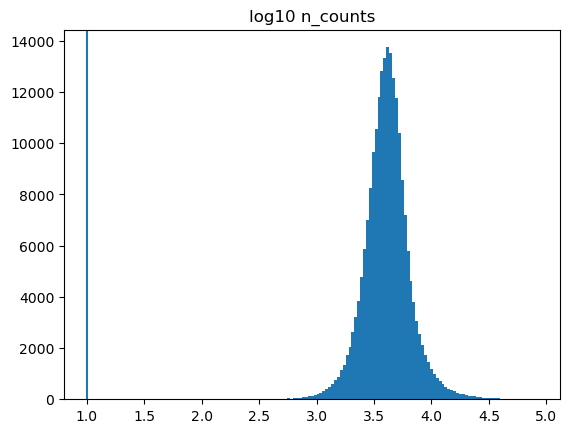

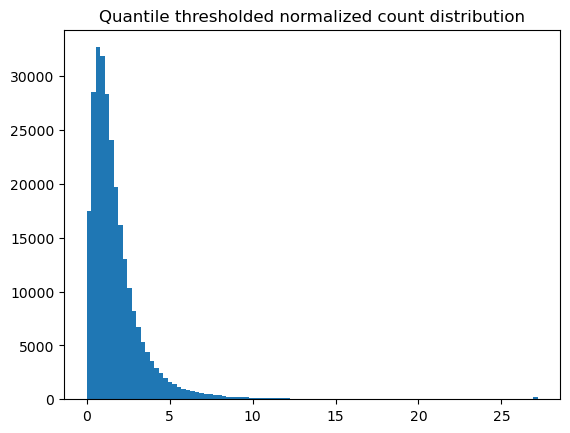

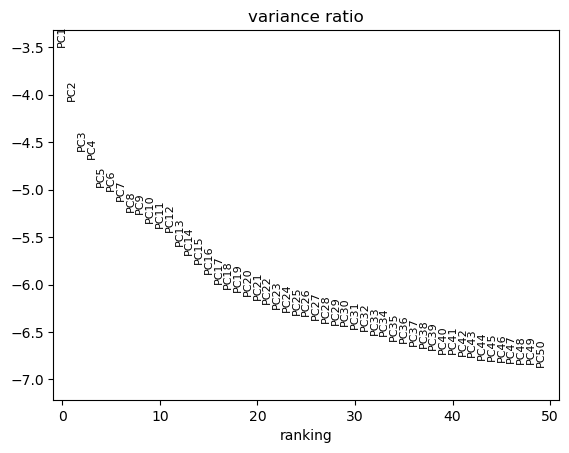

2023-10-09 13:43:10,599 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-10-09 13:43:58,358 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-10-09 13:44:00,653 - harmonypy - INFO - Iteration 1 of 20
2023-10-09 13:46:55,624 - harmonypy - INFO - Iteration 2 of 20
2023-10-09 13:49:57,317 - harmonypy - INFO - Iteration 3 of 20
2023-10-09 13:54:44,190 - harmonypy - INFO - Iteration 4 of 20
2023-10-09 13:59:34,419 - harmonypy - INFO - Iteration 5 of 20
2023-10-09 14:04:02,881 - harmonypy - INFO - Converged after 5 iterations


In [20]:

if params['feature_type_col'] is not None:
    adata_RNA = adata[:, adata.var[params['feature_type_col']]!=params['adt_feature_name']]
    adata_ADT = adata[:, adata.var[params['feature_type_col']]==params['adt_feature_name']]
    
    adata_ADT.var_names_make_unique()
    adata_ADT.var['features_renamed'] = adata_ADT.var.index
    
else:
    adata_RNA = adata
    
adata_RNA.var_names_make_unique()
adata_RNA.var['features_renamed'] = adata_RNA.var.index

p = Preprocess(params['random_seed'])


adata_RNA = p.filter_adata(adata_RNA, filter_mito_thresh=params['filter_mito_thresh'], min_cells_per_gene = params['min_cells_per_RNA_gene'],
             min_counts_per_cell = params['min_rna_counts_per_cell'], filter_mito_genes = params['filter_mito_genes'],
             filter_dot_genes = params['filter_dot_genes'], makeplots=True)

(adata_RNA_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf(adata_RNA, harmony_vars=params['harmony_vars'], n_top_rna_genes = params['n_top_rna_genes'],
                            librarysize_targetsum= 1e4, max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [21]:
adata_RNA_c.obs.to_csv(paths['Metadata'], sep='\t')

In [24]:

import os
os.path.abspath(paths['Metadata'])

'/data/srlab1/TCAT/Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927metadata.tsv'

In [15]:
sc.write(paths['RNA_Varnorm_Harmony'], adata_RNA_c)
sc.write(paths['TP10K'], adata_tp10k)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


In [16]:
with open(paths['RNA_HVG_List'], 'w') as F:
    F.write('\n'.join(hvgs))

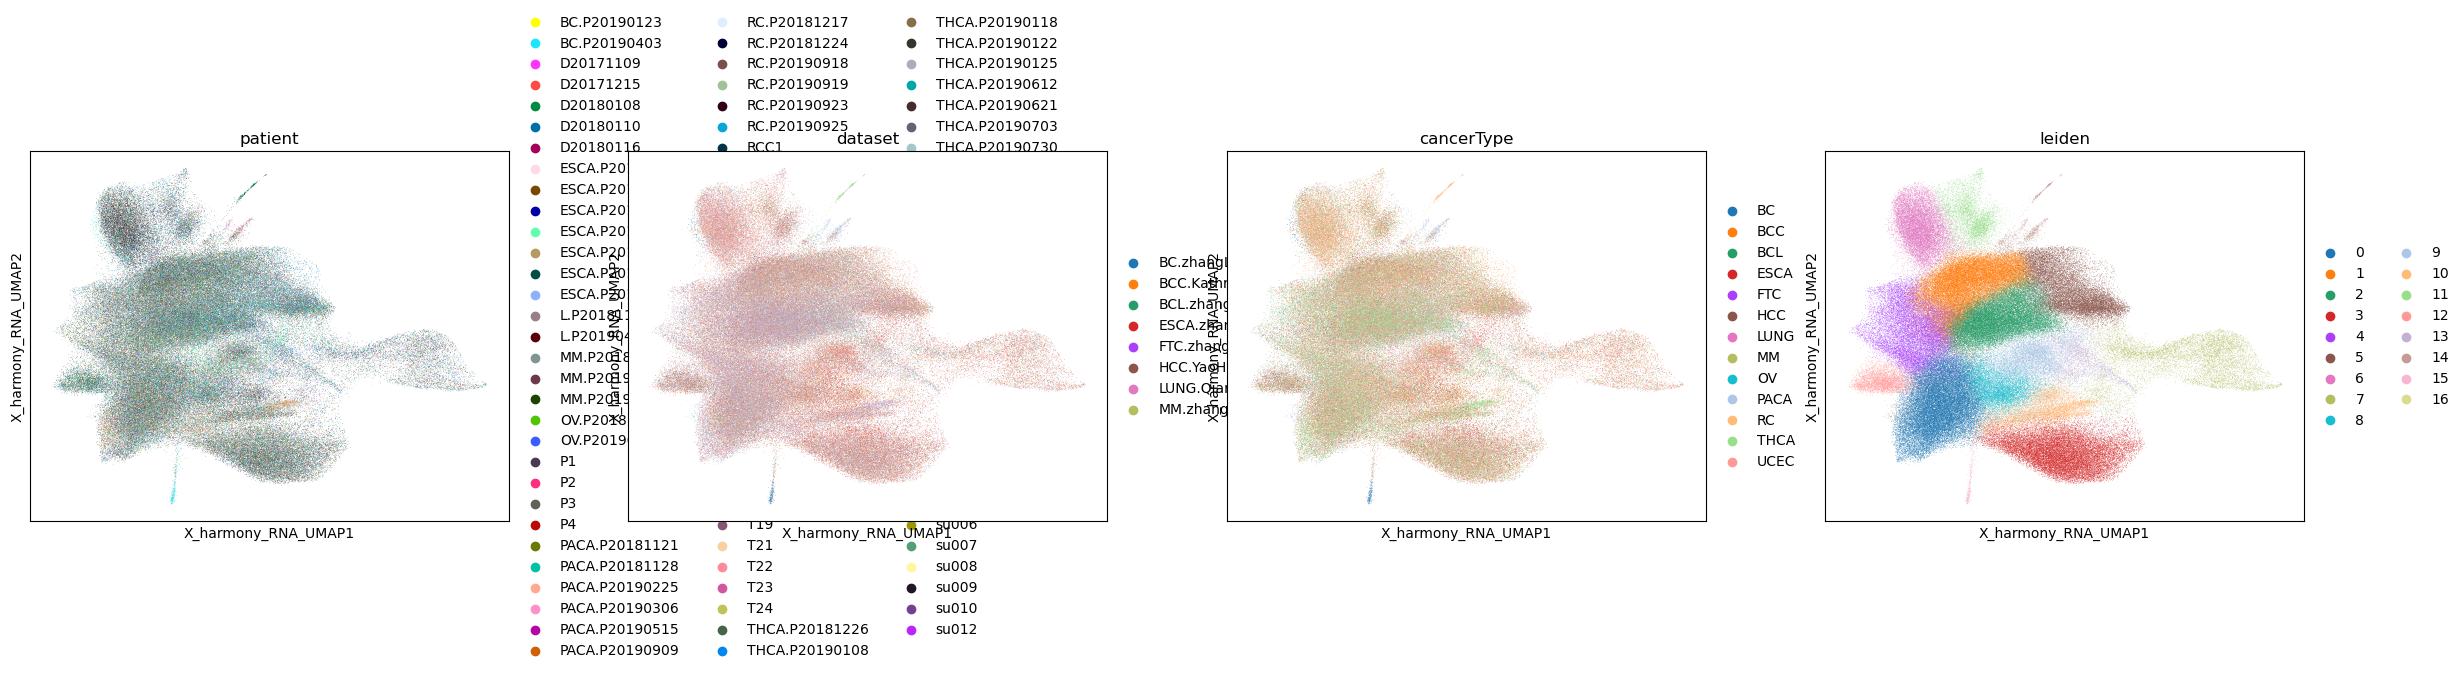

In [17]:
sc.pp.neighbors(adata_RNA_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_rna_pcs'], use_rep='X_pca_harmony')
sc.tl.umap(adata_RNA_c)
adata_RNA_c.obsm['X_harmony_RNA_UMAP'] = adata_RNA_c.obsm['X_umap']
sc.tl.leiden(adata_RNA_c, resolution=1)
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= params['harmony_vars'] + ['leiden'])

In [20]:
adata_RNA_c.obs.columns

Index(['patient', 'cellID', 'libraryID', 'cancerType', 'loc', 'batchV', 'TCR',
       'dataset', 'ClusterID', 'dataset.tech', 'cellID.uniq', 'S.Score',
       'G2M.Score', 'Phase', 'DIG.Score1', 'score.MALAT1', 'percent.mito',
       'miniCluster', 'meta.cluster', 'meta.cluster.coarse',
       'ClusterID.harmony', 'batch', 'n_counts', 'leiden'],
      dtype='object')

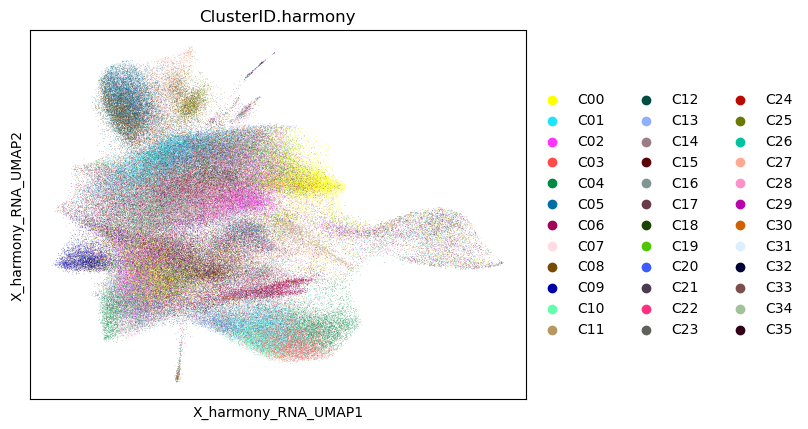

In [21]:
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= [ 'ClusterID.harmony'])

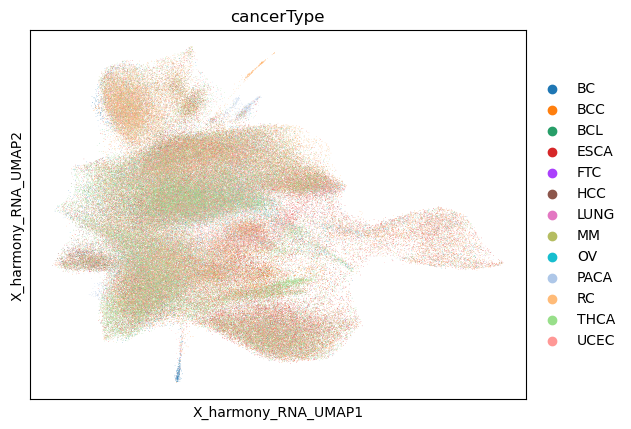

In [22]:
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= ['cancerType'])

In [24]:
sc.write(paths['RNA_Varnorm_Harmony'].replace('.h5ad', '.WithUMAP.h5ad'), adata_RNA_c)


Only considering the two last: ['.WithUMAP', '.h5ad'].
Only considering the two last: ['.WithUMAP', '.h5ad'].


In [6]:
# Filt raw data to cells used for cnmf only 
adata_RNA_c = sc.read(paths['RNA_Varnorm_Harmony'])
adata_filt = adata[adata_RNA_c.obs.index, ]

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


In [7]:
adata.shape, adata_RNA_c.shape, adata_filt.shape

((215048, 18728), (215035, 2000), (215035, 18728))

In [8]:
paths['Raw_Filt_For_cNMF']

'../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.NoPBMC.NoBlood.20230927FiltForcNMF.h5ad'

In [9]:
sc.write(paths['Raw_Filt_For_cNMF'], adata_filt)

Only considering the two last: ['.20230927FiltForcNMF', '.h5ad'].
Only considering the two last: ['.20230927FiltForcNMF', '.h5ad'].


# Run pipeline for all tissues including blood

In [27]:
params = {
'harmony_vars' : ['patient', 'dataset', 'cancerType'],
'filter_mito_thresh' : None,
'RNA_normalize_targetsum' : 1e4,
'n_top_rna_genes' : 2000,
'n_top_adt_genes' : 70,
'feature_type_col' : None,
'adt_feature_name' : None,
'min_cells_per_RNA_gene' : 10,
'min_rna_counts_per_cell' : 500,
'filter_mito_genes' : False,
'filter_dot_genes' : True,
'max_scaled_thresh' : None,
'quantile_thresh' : .9999,
'n_neighbors' : 30,
'n_rna_pcs' : 50,
'n_adt_pcs' : 21,
'name_addition' : '.WithBlood.20230927.', # Set to a string if you want to append that to the name of saved files to run multiple versions of script
'random_seed' : 14
}



if params['name_addition'] is None:
    toadd = ''
else:
    toadd = params['name_addition']


original =  '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.h5ad'
paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_Varnorm_Harmony':original.replace('.h5ad', toadd + 'RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'),
        'RNA_HVG_List':original.replace('.h5ad', toadd + 'RNA.HVGlist.tsv'),
        'Metadata' : original.replace('.h5ad', toadd + 'metadata.tsv')
        }
        
if params['feature_type_col'] is None:
    ## Output RNA only TP10K file if no ADT
    paths['TP10K'] = original.replace('.h5ad', toadd + 'RNA.TP10K.h5ad')
else:
    ## Output both RNA and ADT files
    paths['ADT_MI_Rank'] = original.replace('.h5ad', toadd + 'ADT.TP10K.VarNorm.leidenRNA_MI.tsv')
    paths['ADT_Varnom_Harmony'] = original.replace('.h5ad', toadd + 'ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['RNA_and_ADT_TP10K'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.h5ad')
    paths['RNA_and_ADT_HVG_List'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.HVGlist.tsv')
    paths['RNA_and_ADT_Varnorm_Harmony_WNN'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu')
    paths['RNA_and_ADT_Varnorm_Harmony'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['WNN_UMAP'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv')
    
paths


{'Original': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.WithBlood.20230927.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.WithBlood.20230927.RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.WithBlood.20230927.metadata.tsv',
 'TP10K': '../../../Data/PerDataset/Pancancer/pancancer_zheng.10X.Greater20KgeneDatasets.WithBlood.20230927.RNA.TP10K.h5ad'}

In [28]:
adata = sc.read(paths['Original'])

Only considering the two last: ['.Greater20KgeneDatasets', '.h5ad'].
Only considering the two last: ['.Greater20KgeneDatasets', '.h5ad'].


In [29]:
complete_meta = pd.read_csv('../../../Data/PerDataset/Pancancer/Complete_Published_Metadata.csv', sep=',', index_col=0)
complete_meta.head()

/tmp/ipykernel_14044/2700157535.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  complete_meta = pd.read_csv('../../../Data/PerDataset/Pancancer/Complete_Published_Metadata.csv', sep=',', index_col=0)


,patient,cellID,libraryID,cancerType,loc,batchV,TCR,dataset,ClusterID,dataset.tech,...,dataset.old,sampleID,treatment,stype,patient.uid,usedForFreq,dataSource,tech,tech.cate,pub
1,BC9,s1_AAACCTGAGCAGACTG-1,BC9T,BRCA,T,BC9,NaN,BRCA.ElhamAzizi2018.10X,BC.Elham2018.10X.C01,Elham2018.10X,...,BC.Elham2018.10X,BC9T,baseline,CD8,BRCA.ElhamAzizi2018.10X.BC9,Y,other labs,10X,Droplet,published
2,BC9,s1_AAACCTGAGGTCGGAT-1,BC9T,BRCA,T,BC9,NaN,BRCA.ElhamAzizi2018.10X,BC.Elham2018.10X.C06,Elham2018.10X,...,BC.Elham2018.10X,BC9T,baseline,CD8,BRCA.ElhamAzizi2018.10X.BC9,Y,other labs,10X,Droplet,published
3,BC9,s1_AAACCTGAGTGTACTC-1,BC9T,BRCA,T,BC9,NaN,BRCA.ElhamAzizi2018.10X,BC.Elham2018.10X.C01,Elham2018.10X,...,BC.Elham2018.10X,BC9T,baseline,CD8,BRCA.ElhamAzizi2018.10X.BC9,Y,other labs,10X,Droplet,published
4,BC9,s1_AAACCTGCAGATGGGT-1,BC9T,BRCA,T,BC9,NaN,BRCA.ElhamAzizi2018.10X,BC.Elham2018.10X.C04,Elham2018.10X,...,BC.Elham2018.10X,BC9T,baseline,CD8,BRCA.ElhamAzizi2018.10X.BC9,Y,other labs,10X,Droplet,published
5,BC9,s1_AAACCTGGTAGCACGA-1,BC9T,BRCA,T,BC9,NaN,BRCA.ElhamAzizi2018.10X,BC.Elham2018.10X.C00,Elham2018.10X,...,BC.Elham2018.10X,BC9T,baseline,CD8,BRCA.ElhamAzizi2018.10X.BC9,Y,other labs,10X,Droplet,published


In [30]:
tech = complete_meta[['libraryID', 'tech']].drop_duplicates()
tech.index = tech['libraryID']

In [31]:
tech.loc[adata.obs['libraryID'], 'tech'].value_counts()

10X    228349
Name: tech, dtype: int64

In [32]:
pd.crosstab(adata.obs['cancerType'], adata.obs['loc'])

loc,N,P,T
cancerType,,,
BC,3206,0,4148
BCC,0,0,21011
BCL,0,4226,3493
ESCA,9768,0,15116
FTC,0,0,1037
HCC,5068,5080,5898
LUNG,1018,0,187
MM,0,3995,8279
OV,910,0,3613


In [33]:
adata.obs['cancerType'].value_counts()

THCA    56958
UCEC    32655
RC      31177
ESCA    24884
BCC     21011
HCC     16046
MM      12274
PACA    11506
BCL      7719
BC       7354
OV       4523
LUNG     1205
FTC      1037
Name: cancerType, dtype: int64

In [34]:
adata.obs['loc'].value_counts()

T    139386
N     75662
P     13301
Name: loc, dtype: int64

In [35]:
adata.X = adata.X.astype(np.float32)

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


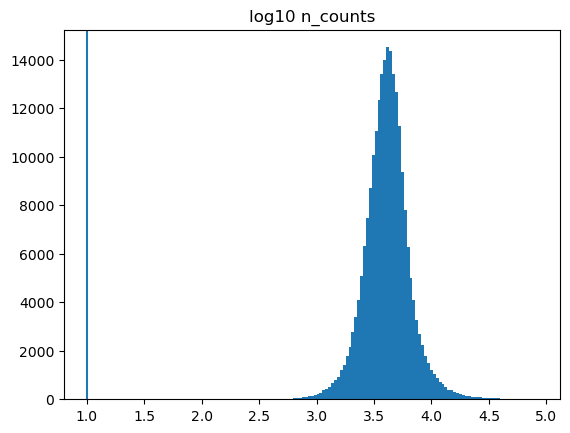

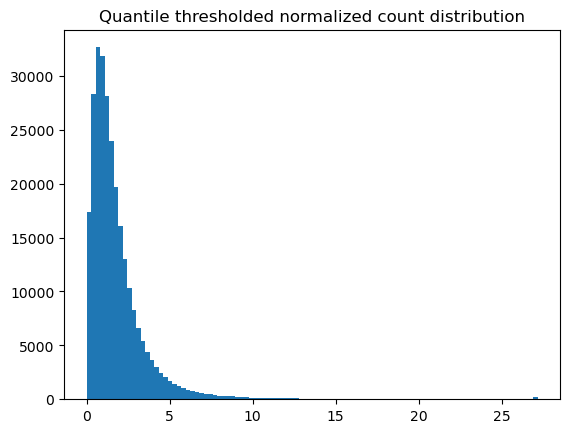

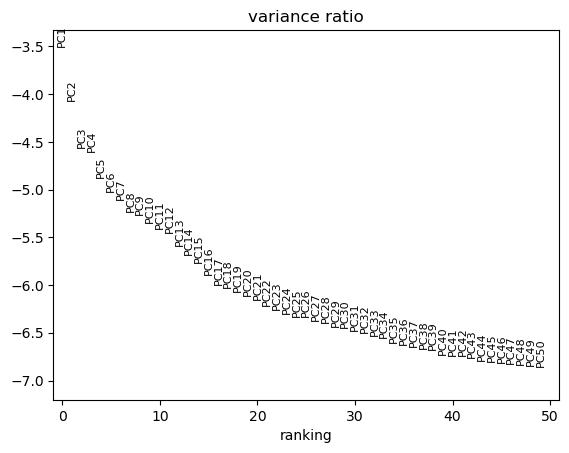

2023-10-05 15:42:52,155 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-10-05 15:43:44,078 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-10-05 15:43:46,503 - harmonypy - INFO - Iteration 1 of 20
2023-10-05 15:46:45,397 - harmonypy - INFO - Iteration 2 of 20
2023-10-05 15:49:48,002 - harmonypy - INFO - Iteration 3 of 20
2023-10-05 15:52:50,551 - harmonypy - INFO - Iteration 4 of 20
2023-10-05 15:56:17,194 - harmonypy - INFO - Iteration 5 of 20
2023-10-05 15:59:18,641 - harmonypy - INFO - Converged after 5 iterations


In [36]:

if params['feature_type_col'] is not None:
    adata_RNA = adata[:, adata.var[params['feature_type_col']]!=params['adt_feature_name']]
    adata_ADT = adata[:, adata.var[params['feature_type_col']]==params['adt_feature_name']]
    
    adata_ADT.var_names_make_unique()
    adata_ADT.var['features_renamed'] = adata_ADT.var.index
    
else:
    adata_RNA = adata
    
adata_RNA.var_names_make_unique()
adata_RNA.var['features_renamed'] = adata_RNA.var.index

p = Preprocess(params['random_seed'])


adata_RNA = p.filter_adata(adata_RNA, filter_mito_thresh=params['filter_mito_thresh'], min_cells_per_gene = params['min_cells_per_RNA_gene'],
             min_counts_per_cell = params['min_rna_counts_per_cell'], filter_mito_genes = params['filter_mito_genes'],
             filter_dot_genes = params['filter_dot_genes'], makeplots=True)

(adata_RNA_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf(adata_RNA, harmony_vars=params['harmony_vars'], n_top_rna_genes = params['n_top_rna_genes'],
                            librarysize_targetsum= 1e4, max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [37]:
sc.write(paths['RNA_Varnorm_Harmony'], adata_RNA_c)
sc.write(paths['TP10K'], adata_tp10k)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


In [38]:
with open(paths['RNA_HVG_List'], 'w') as F:
    F.write('\n'.join(hvgs))

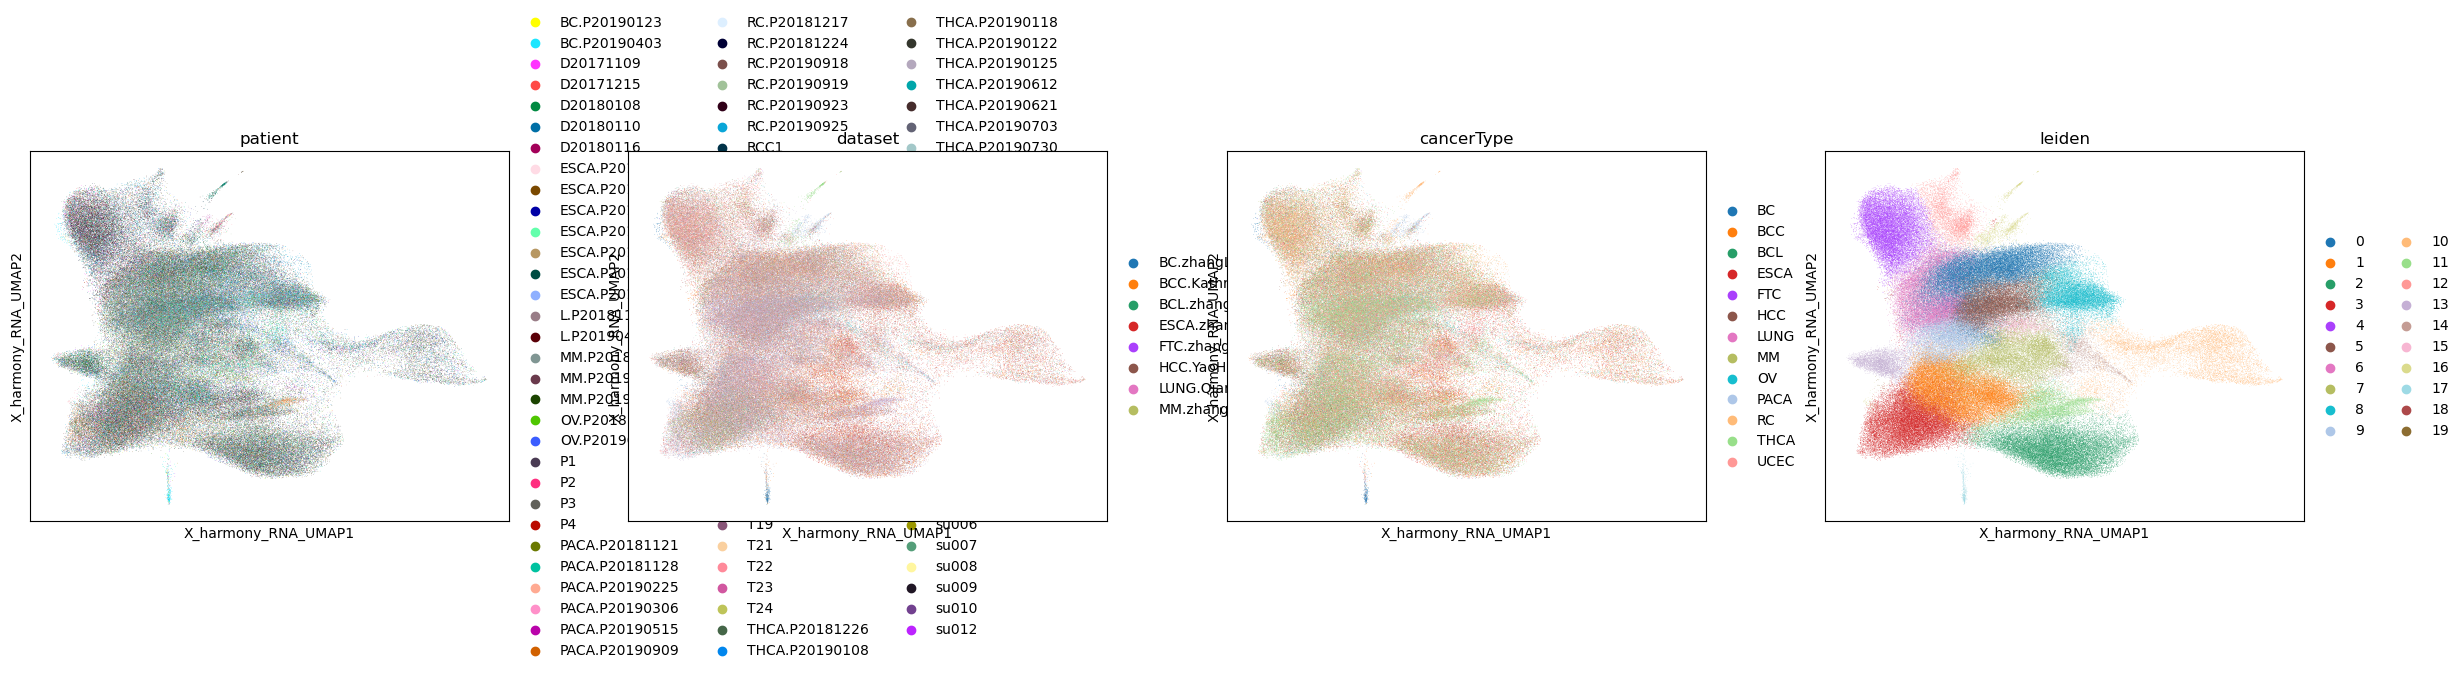

In [39]:
sc.pp.neighbors(adata_RNA_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_rna_pcs'], use_rep='X_pca_harmony')
sc.tl.umap(adata_RNA_c)
adata_RNA_c.obsm['X_harmony_RNA_UMAP'] = adata_RNA_c.obsm['X_umap']
sc.tl.leiden(adata_RNA_c, resolution=1)
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= params['harmony_vars'] + ['leiden'])

In [40]:
adata_RNA_c.obs.columns

Index(['patient', 'cellID', 'libraryID', 'cancerType', 'loc', 'batchV', 'TCR',
       'dataset', 'ClusterID', 'dataset.tech', 'cellID.uniq', 'S.Score',
       'G2M.Score', 'Phase', 'DIG.Score1', 'score.MALAT1', 'percent.mito',
       'miniCluster', 'meta.cluster', 'meta.cluster.coarse',
       'ClusterID.harmony', 'batch', 'n_counts', 'leiden'],
      dtype='object')

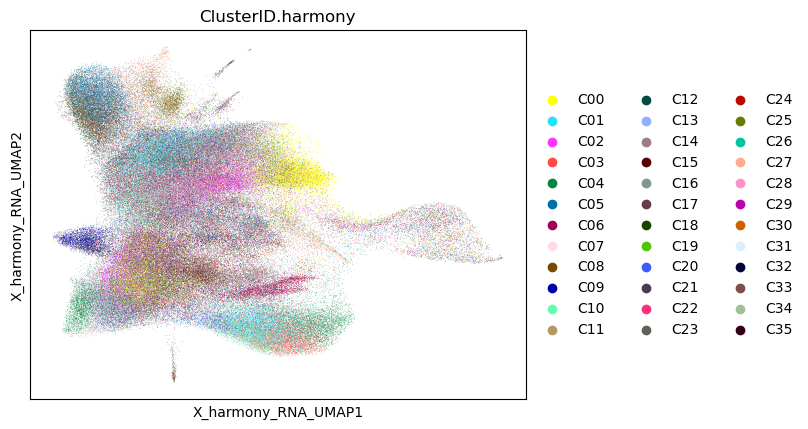

In [41]:
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= [ 'ClusterID.harmony'])

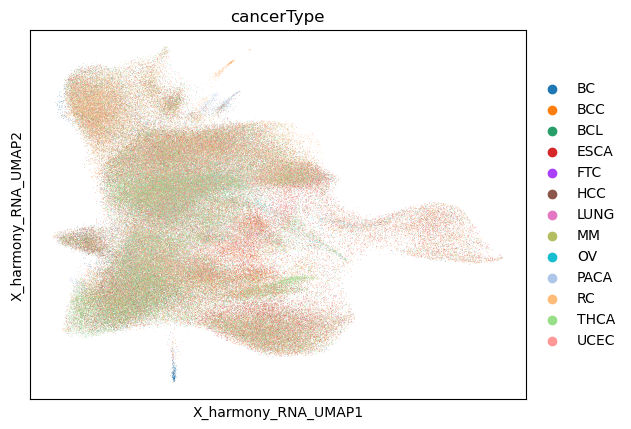

In [42]:
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= ['cancerType'])

In [43]:
sc.write(paths['RNA_Varnorm_Harmony'].replace('.h5ad', '.WithUMAP.h5ad'), adata_RNA_c)


Only considering the two last: ['.WithUMAP', '.h5ad'].
Only considering the two last: ['.WithUMAP', '.h5ad'].
